In [1]:
import numpy as np
import pandas as pd


import random
import os
from astropy.io import fits
from astropy.table import Table

from PIL import Image, ImageOps
from fpdf import FPDF

import matplotlib.pyplot as plt
from astropy.visualization import make_lupton_rgb
plt.style.use('dark_background')

In [2]:
filepath = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/vit_cnn_multiclass/results/data/'
hdu_list = fits.open(filepath + 'Unique_positives_complete.fits')
images = hdu_list[1].data
images = images[:,0:3,:,:]
data = pd.DataFrame(hdu_list[2].data)
print(len(data))

data = data.drop_duplicates(subset=['COADD_OBJECT_ID'], keep='first')
images = images[data.index]
#data = data.reset_index(drop = True)
hdu_list.close()

print(len(data), len(images))

20642
20639 20639


In [3]:
def plot_image(coadd_id):
    filepath = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/vit_cnn_multiclass/results/data/'
    hdu_list = fits.open(filepath + 'Unique_positives_complete.fits')
    images = hdu_list[1].data
    images = images[:,0:3,:,:]
    data = pd.DataFrame(hdu_list[2].data)
    print(len(data))
    data = data.drop_duplicates(subset=['COADD_OBJECT_ID'], keep='first')
    images = images[data.index]
    hdu_list.close()

    data_tmp = data[data['COADD_OBJECT_ID'] == coadd_id]
    image_tmp = images[data_tmp.index][0]
    
    rgb = make_lupton_rgb(image_tmp[2], image_tmp[1], image_tmp[0], Q=11., stretch=40.)
    
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(rgb, aspect='equal')
    plt.xticks([], [])
    plt.yticks([], []) 
    plt.show()
    #plt.savefig(title, bbox_inches='tight')
    #plt.close()

20642


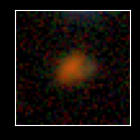

In [4]:
plot_image(1057397611)

In [5]:
# Writes fit file
def write_fit_file(name, x, data):
    my_types = {'COADD_OBJECT_ID': int, 'TILENAME': str, 'PROB': float, 'HPIX_16384': int, 'HPIX_4096': int,
       'DNF_ZMEAN_SOF': float, 'RA': float, 'DEC': float, 'FLUX_RADIUS_G': float, 'FLUX_RADIUS_R': float,
       'FLUX_RADIUS_I': float, 'FLUX_RADIUS_Z': float, 'KRON_RADIUS': float, 'GAP_FLUX_G': float,
       'MOF_BDF_FLUX_G': float, 'MOF_PSF_FLUX_G': float, 'SOF_BDF_FLUX_G': float, 'SOF_PSF_FLUX_G': float,
       'MAG_AUTO_G': float, 'MAG_APER_4_G': float, 'MAG_APER_8_G': float, 'SOF_BDF_G_1': float,
       'SOF_BDF_G_2': float, 'IMAFLAGS_ISO_G': int, 'IMAFLAGS_ISO_R': int, 'IMAFLAGS_ISO_I': int,
       'IMAFLAGS_ISO_Z': int, 'EXT_COADD': int}
    data = data.astype(my_types)
    
    primary = fits.PrimaryHDU()
    image = fits.ImageHDU(x, name="IMAGE")
    table_data = Table.from_pandas(data)
    table = fits.BinTableHDU(data = table_data)
    hdu_list = fits.HDUList([primary, image, table])
    hdu_list.writeto(filepath + name + '.fits', overwrite=True)   
    hdu_list.close()

In [6]:
# Systems for visual inspection
data_tmp = data.sort_values('PROB', ascending=False)
data_tmp = data_tmp.head(7000)
data_tmp = data_tmp.sort_index()
data_tmp.columns

num = 1000 #1000

# Writing a fit file for each group
filepath = 'fit_files/'

for i in range(7):
    new_data = data_tmp.iloc[i*num: i*num + num]
    new_images = images[new_data.index]
    
    new_id = list(range(i*num, i*num + num))
    new_data['new_id'] = new_id
    
    new_data.to_csv('fit_files/group_' + str(i+1) + '.csv')
    write_fit_file('group_' + str(i+1) , new_images, new_data)

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [7]:
def make_image(objects, data, title):
    #new_title = 'Prob: {:.2f}'.format(data['PROB'])
    rgb = make_lupton_rgb(objects[2], objects[1], objects[0], Q=11., stretch=40.)
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(rgb, aspect='equal')
    plt.xticks([], [])
    plt.yticks([], []) 
    plt.savefig(title, bbox_inches='tight')
    plt.close()
    #plt.show()

In [8]:
# Writing all pdf files
for j in range(7):
    if(j != 0): continue
    pdf = FPDF('L', 'mm', (80, 150))
    
    hdu_list = fits.open(filepath + 'group_' + str(j+1) + '.fits')
    images_tmp = hdu_list[1].data 
    data_tmp = pd.DataFrame(hdu_list[2].data)
    hdu_list.close()
    
    print(len(images_tmp), len(data_tmp))
    
    duplicates = data_tmp[data_tmp.duplicated(['COADD_OBJECT_ID'], keep=False)]
    if(len(duplicates) > 0):
        print("There are duplicates!")
    
    print('After duplicated')
    for i in range(len(images_tmp)):
        new_image = images_tmp[i].transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(100*new_image)).convert("RGB")
    
        title = 'Cutouts/' + str(data_tmp['COADD_OBJECT_ID'].iloc[i]) + '.png'
    
        make_image(images_tmp[i], data.iloc[i], title)
        #width, height = new_image.size
        pdf.add_page()
        pdf.set_font("Arial", size=24)
        if(data_tmp['new_id'].iloc[i] % 20 == 0):
            pdf.set_text_color(86,189,89)  
        else:
            pdf.set_text_color(0,0,0)
        pdf.cell(0, 0, str(data_tmp['new_id'].iloc[i]), align="L")
        pdf.image(title, 3, 20)

    pdf.output("pdf_files/Group_" + str(j+1) + ".pdf", "F")
    

1000 1000
After duplicated
